# Risk Parity Lookback Analysis - Commodity Futures

Test di diversi periodi di lookback per il risk parity portfolio su strategie contrarian commodity futures.

**IMPORTANTE**: Il portfolio viene ribilanciato **giornalmente** invece che settimanalmente, con pesi laggati di 1 giorno per evitare lookahead bias e **commissioni IBKR realistiche** per futures.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import warnings
import sys
sys.path.append('../../modules')
from strategy_contrarian import rebalance_risk_parity
warnings.filterwarnings('ignore')

# Configurazione plot
plt.rcParams['figure.figsize'] = (15, 10)
plt.rcParams['axes.grid'] = True

def clean_data(df):
    """Pulisce completamente i dati da infiniti e NaN"""
    df_clean = df.replace([np.inf, -np.inf], np.nan)
    df_clean = df_clean.fillna(method='ffill')
    df_clean = df_clean.fillna(0)
    mask = ~np.isfinite(df_clean.values)
    if mask.any():
        df_clean = df_clean.mask(mask, 0)
    return df_clean

print("Setup completato - Commodity Futures Lookback Analysis")

Setup completato - Commodity Futures Lookback Analysis


## 1. Caricamento Dati Commodity Futures

In [2]:
# Carica equity curves delle strategie contrarian commodity futures
results_dir = Path('../data/results')

# Load parquet file
equity_curves = pd.read_parquet(results_dir / 'all_equity_curves.parquet')

# Pulisci e converti in price series per risk parity
equity_curves = clean_data(equity_curves)

# IMPORTANTE: Assicurati che l'index sia DatetimeIndex
if not isinstance(equity_curves.index, pd.DatetimeIndex):
    equity_curves.index = pd.to_datetime(equity_curves.index)

strategy_prices = (1 + equity_curves).fillna(1)

# Assicurati che anche strategy_prices abbia DatetimeIndex
if not isinstance(strategy_prices.index, pd.DatetimeIndex):
    strategy_prices.index = pd.to_datetime(strategy_prices.index)

print(f"Commodity Futures equity curves caricate: {equity_curves.shape}")
print(f"Date range: {equity_curves.index.min()} to {equity_curves.index.max()}")
print(f"Index type: {type(equity_curves.index)}")
print(f"Commodity Futures disponibili: {list(equity_curves.columns)}")

# Verifica che dayofweek funzioni
print(f"Test dayofweek: {equity_curves.index.dayofweek[:5].tolist()}")

# Mostra performance preliminari
final_returns = equity_curves.iloc[-1].sort_values(ascending=False)
print(f"\n=== TOP 5 COMMODITY FUTURES (senza ottimizzazione lookback) ===")
for ticker, ret in final_returns.head(5).items():
    print(f"{ticker}: {ret:.1%}")

Commodity Futures equity curves caricate: (5696, 15)
Date range: 2010-01-04 00:00:00 to 2025-08-08 00:00:00
Index type: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
Commodity Futures disponibili: ['CL=F', 'NG=F', 'BZ=F', 'RB=F', 'HO=F', 'GC=F', 'SI=F', 'HG=F', 'PA=F', 'ZC=F', 'ZW=F', 'ZS=F', 'SB=F', 'CT=F', 'CC=F']
Test dayofweek: [0, 1, 2, 3, 4]

=== TOP 5 COMMODITY FUTURES (senza ottimizzazione lookback) ===
NG=F: 2829.0%
SI=F: 543.9%
RB=F: 284.4%
GC=F: 156.0%
BZ=F: 119.6%


## 2. Definizione Periodi di Lookback

Testiamo gli stessi periodi del forex ma su commodity futures che potrebbero avere dinamiche diverse:

In [3]:
# Definisci periodi di lookback da testare (identici a forex per confrontabilità)
lookback_periods = {
    '1 settimana': 7,
    '2 settimane': 14, 
    '1 mese': 22,  # Default
    '6 settimane': 44,
    '2 mesi': 44,
    '3 mesi': 66,
    '6 mesi': 132
}

print("Periodi di lookback da testare su COMMODITY FUTURES:")
for name, days in lookback_periods.items():
    print(f"- {name}: {days} giorni")
    
# Altri parametri fissi
THRESHOLD = -0.1  # Soglia performance minima
SHIFT = 1        # Giorni di shift per evitare lookahead bias (CRITICO: pesi laggati di 1 giorno)

print(f"\n⚠️  NOTA IMPORTANTE: Portfolio commodity futures ribilanciato GIORNALMENTE con pesi laggati di {SHIFT} giorno(i)")
print(f"⚠️  COMMISSIONI: Applicate commissioni IBKR realistiche per futures ($2-4 per round-trip)")

Periodi di lookback da testare su COMMODITY FUTURES:
- 1 settimana: 7 giorni
- 2 settimane: 14 giorni
- 1 mese: 22 giorni
- 6 settimane: 44 giorni
- 2 mesi: 44 giorni
- 3 mesi: 66 giorni
- 6 mesi: 132 giorni

⚠️  NOTA IMPORTANTE: Portfolio commodity futures ribilanciato GIORNALMENTE con pesi laggati di 1 giorno(i)
⚠️  COMMISSIONI: Applicate commissioni IBKR realistiche per futures ($2-4 per round-trip)


## 3. Test di Tutti i Lookback Periods

In [4]:
# Storage per risultati
portfolio_results = {}
performance_summary = []

print("Testing diversi lookback periods su COMMODITY FUTURES...\n")
print("⚠️  NOTA: Risk parity ora ribilancia GIORNALMENTE (non più settimanalmente)")
print("⚠️  NOTA: I pesi vengono laggati di 1 giorno per evitare lookahead bias")
print("⚠️  NOTA: Applicate commissioni IBKR realistiche per futures ($2-4 per round-trip)\n")

for period_name, n_days in lookback_periods.items():
    print(f"Testing {period_name} ({n_days} giorni)...")
    
    try:
        # Applica risk parity con questo lookback period
        # IMPORTANTE: Ora ribilancia giornalmente con pesi laggati
        portfolio_df = rebalance_risk_parity(
            df_balance=strategy_prices, 
            n=n_days, 
            threshold=THRESHOLD, 
            shift=SHIFT  # Pesi laggati di 1 giorno
        )
        
        # Pulisci risultati
        portfolio_df = clean_data(portfolio_df)
        equity_series = portfolio_df['equity']
        
        # Calcola metriche performance
        final_equity = equity_series.iloc[-1]
        total_return = (final_equity - 1.0) * 100
        
        # Calcola ritorni giornalieri per Sharpe e volatilità
        daily_returns = equity_series.pct_change().dropna()
        daily_returns = daily_returns.replace([np.inf, -np.inf], 0)
        
        annual_return = daily_returns.mean() * 252
        volatility = daily_returns.std() * np.sqrt(252)
        sharpe_ratio = annual_return / volatility if volatility > 0 else 0
        
        # Max drawdown
        rolling_max = equity_series.expanding().max()
        drawdown = (equity_series - rolling_max) / rolling_max
        max_drawdown = drawdown.min()
        
        # Salva risultati
        portfolio_results[period_name] = {
            'equity': equity_series,
            'portfolio_df': portfolio_df,
            'n_days': n_days
        }
        
        performance_summary.append({
            'Lookback': period_name,
            'Days': n_days,
            'Final Equity': final_equity,
            'Total Return (%)': total_return,
            'Annual Return': annual_return,
            'Volatility': volatility, 
            'Sharpe Ratio': sharpe_ratio,
            'Max Drawdown': max_drawdown
        })
        
        print(f"  Final equity: {final_equity:.4f} ({total_return:.2f}%)")
        
    except Exception as e:
        print(f"  ERROR: {e}")
        continue

print(f"\nCompletati {len(portfolio_results)} test su {len(lookback_periods)} su COMMODITY FUTURES")

Testing diversi lookback periods su COMMODITY FUTURES...

⚠️  NOTA: Risk parity ora ribilancia GIORNALMENTE (non più settimanalmente)
⚠️  NOTA: I pesi vengono laggati di 1 giorno per evitare lookahead bias
⚠️  NOTA: Applicate commissioni IBKR realistiche per futures ($2-4 per round-trip)

Testing 1 settimana (7 giorni)...
  Final equity: 2.4073 (140.73%)
Testing 2 settimane (14 giorni)...
  Final equity: 1.0956 (9.56%)
Testing 1 mese (22 giorni)...
  Final equity: 1.1709 (17.09%)
Testing 6 settimane (44 giorni)...
  Final equity: 1.3159 (31.59%)
Testing 2 mesi (44 giorni)...
  Final equity: 1.3159 (31.59%)
Testing 3 mesi (66 giorni)...
  Final equity: 1.3916 (39.16%)
Testing 6 mesi (132 giorni)...
  Final equity: 1.4616 (46.16%)

Completati 7 test su 7 su COMMODITY FUTURES


## 4. Tabella Riassuntiva Performance Commodity Futures

In [5]:
# Crea tabella performance commodity futures
performance_df = pd.DataFrame(performance_summary)
performance_df = performance_df.sort_values('Total Return (%)', ascending=False)

print("=== PERFORMANCE COMPARISON BY LOOKBACK - COMMODITY FUTURES ===\n")
print(performance_df.round(4))

# Trova il migliore per commodity futures
best_performer = performance_df.iloc[0]
print(f"\n🏆 MIGLIORE LOOKBACK PER COMMODITY FUTURES: {best_performer['Lookback']} ({best_performer['Days']} giorni)")
print(f"   Return: {best_performer['Total Return (%)']:.2f}%")
print(f"   Sharpe: {best_performer['Sharpe Ratio']:.3f}")
print(f"   Max DD: {best_performer['Max Drawdown']*100:.2f}%")

=== PERFORMANCE COMPARISON BY LOOKBACK - COMMODITY FUTURES ===

      Lookback  Days  Final Equity  Total Return (%)  Annual Return  \
0  1 settimana     7        2.4073          140.7295         0.0440   
6       6 mesi   132        1.4616           46.1581         0.0187   
5       3 mesi    66        1.3916           39.1566         0.0165   
4       2 mesi    44        1.3159           31.5870         0.0141   
3  6 settimane    44        1.3159           31.5870         0.0141   
2       1 mese    22        1.1709           17.0924         0.0091   
1  2 settimane    14        1.0956            9.5646         0.0067   

   Volatility  Sharpe Ratio  Max Drawdown  
0      0.1015        0.4333       -0.3310  
6      0.0624        0.3005       -0.1993  
5      0.0616        0.2682       -0.1952  
4      0.0625        0.2257       -0.2325  
3      0.0625        0.2257       -0.2325  
2      0.0651        0.1399       -0.2718  
1      0.0730        0.0921       -0.1995  

🏆 MIGLIORE LOO

## 5. Confronto Equity Curves - Risk Parity Ottimizzate Commodity Futures

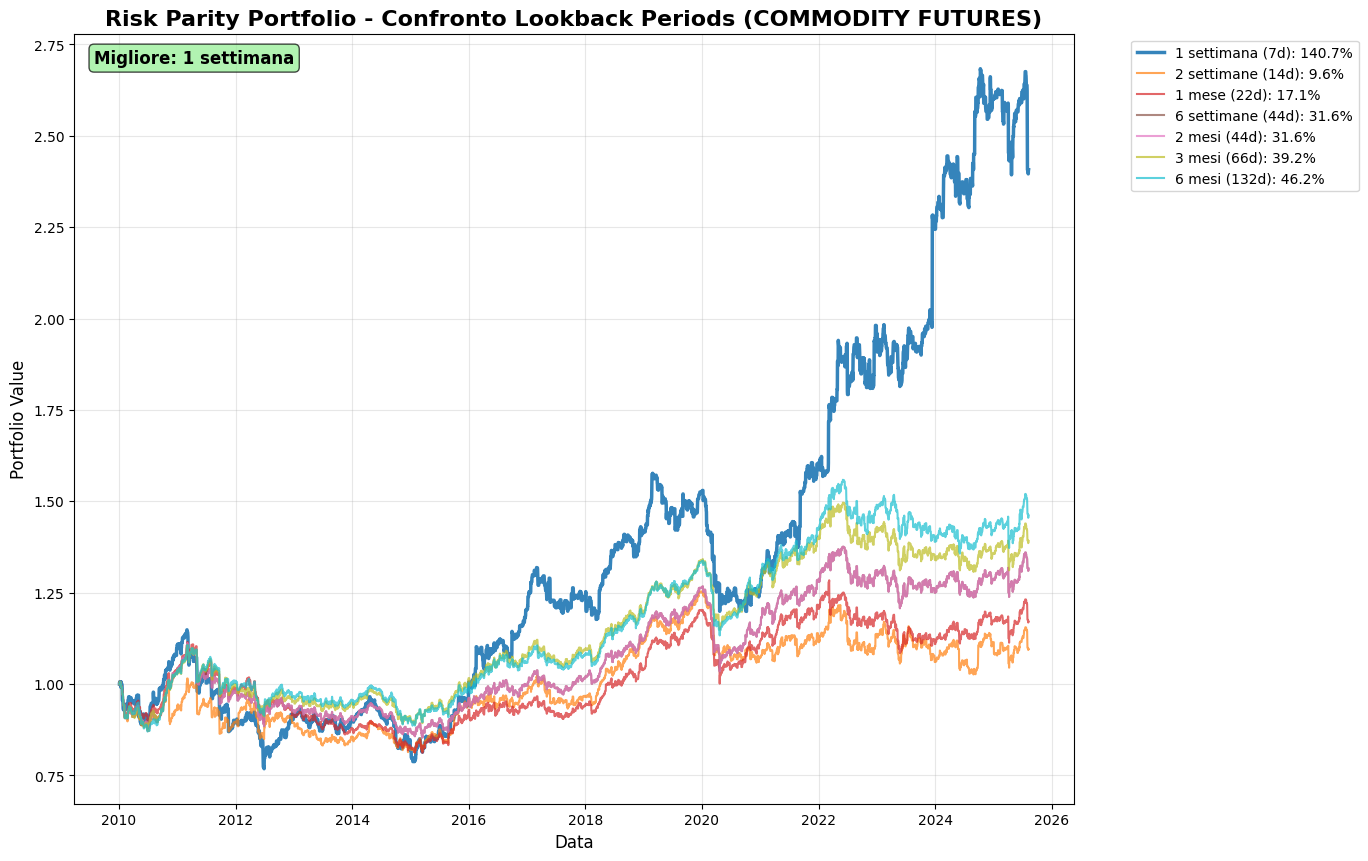

In [6]:
# Plot equity curves di tutti i lookback periods per commodity futures
fig, ax = plt.subplots(figsize=(16, 10))

# Colori per ogni linea
colors = plt.cm.tab10(np.linspace(0, 1, len(portfolio_results)))

for i, (period_name, results) in enumerate(portfolio_results.items()):
    equity = results['equity']
    n_days = results['n_days']
    final_return = (equity.iloc[-1] - 1) * 100
    
    ax.plot(
        equity.index, 
        equity.values, 
        label=f"{period_name} ({n_days}d): {final_return:.1f}%", 
        linewidth=2.5 if period_name == best_performer['Lookback'] else 1.5,
        alpha=0.9 if period_name == best_performer['Lookback'] else 0.7,
        color=colors[i]
    )

ax.set_title('Risk Parity Portfolio - Confronto Lookback Periods (COMMODITY FUTURES)', 
             fontsize=16, fontweight='bold')
ax.set_xlabel('Data', fontsize=12)
ax.set_ylabel('Portfolio Value', fontsize=12)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
ax.grid(True, alpha=0.3)

# Evidenzia il migliore nel titolo
ax.text(0.02, 0.98, f'Migliore: {best_performer["Lookback"]}', 
        transform=ax.transAxes, fontsize=12, fontweight='bold',
        bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.7),
        verticalalignment='top')

plt.subplots_adjust(right=0.75)
plt.show()

## 6. Analisi Drawdown Commodity Futures

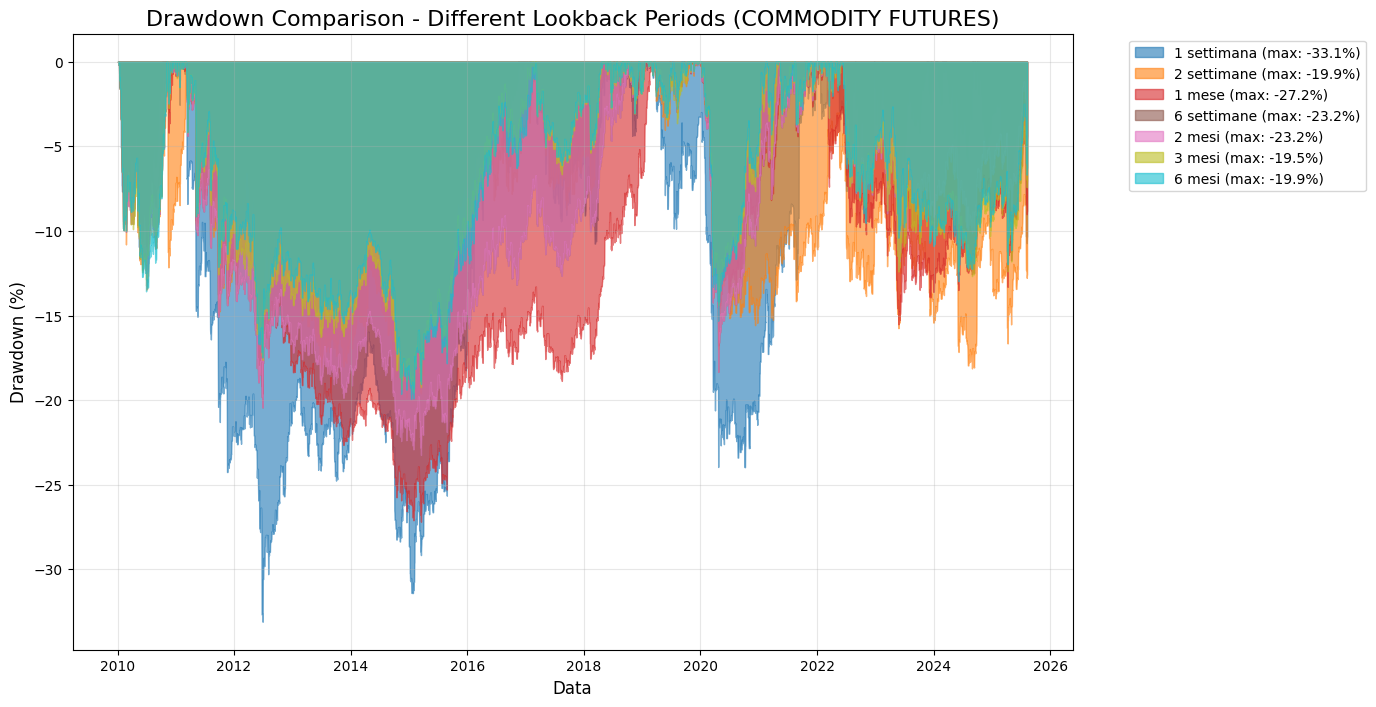

In [7]:
# Plot drawdown comparison per commodity futures
fig, ax = plt.subplots(figsize=(16, 8))

for i, (period_name, results) in enumerate(portfolio_results.items()):
    equity = results['equity']
    
    # Calcola drawdown
    rolling_max = equity.expanding().max()
    drawdown = (equity - rolling_max) / rolling_max * 100
    
    ax.fill_between(
        drawdown.index, 
        drawdown.values, 
        0,
        label=f"{period_name} (max: {drawdown.min():.1f}%)", 
        alpha=0.6,
        color=colors[i]
    )

ax.set_title('Drawdown Comparison - Different Lookback Periods (COMMODITY FUTURES)', fontsize=16)
ax.set_xlabel('Data', fontsize=12)
ax.set_ylabel('Drawdown (%)', fontsize=12)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
ax.grid(True, alpha=0.3)

plt.subplots_adjust(right=0.75)
plt.show()

## 7. Confronto con Equal Weight Benchmark - Commodity Futures

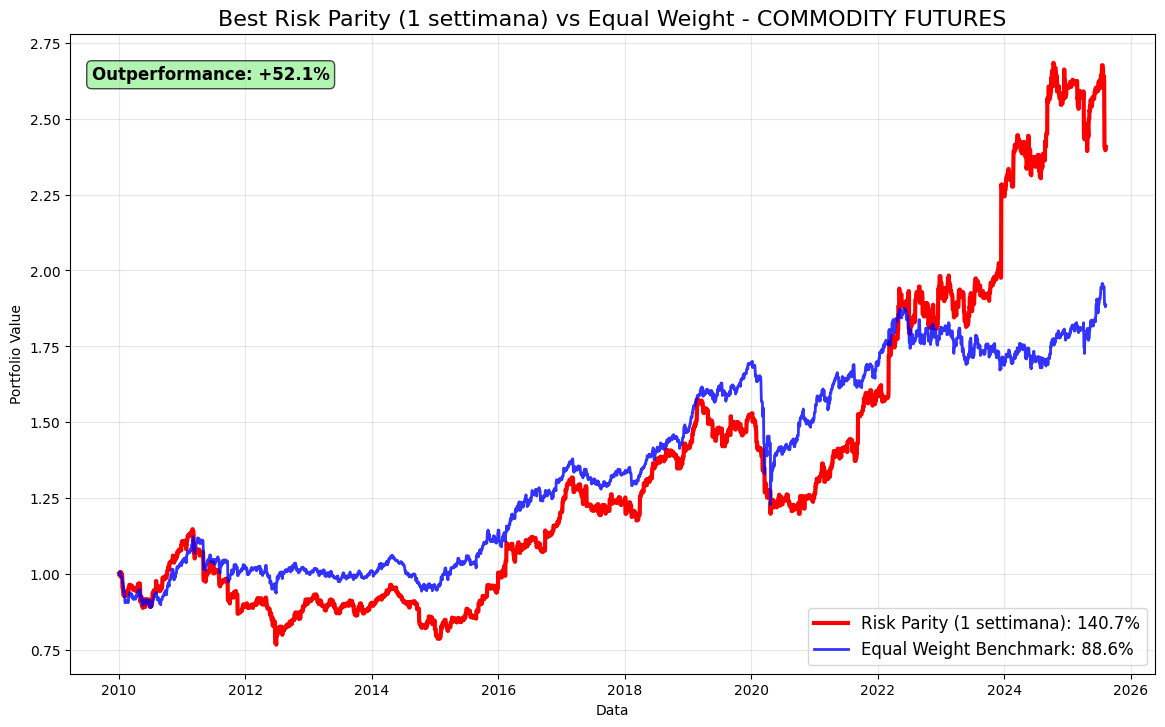


=== CONFRONTO FINALE - COMMODITY FUTURES ===
Best Risk Parity (1 settimana): 140.73%
Equal Weight Benchmark: 88.65%
Outperformance: +52.08%


In [8]:
# Calcola Equal Weight Benchmark per commodity futures
equity_prices = 1 + equity_curves
daily_returns = equity_prices.pct_change().fillna(0)
equal_weight_returns = daily_returns.mean(axis=1)
equal_weight_equity = (1 + equal_weight_returns).cumprod()
equal_weight_clean = clean_data(equal_weight_equity.to_frame()).iloc[:, 0]

# Plot: Best Risk Parity vs Equal Weight per commodity futures
fig, ax = plt.subplots(figsize=(14, 8))

# Best risk parity
best_name = best_performer['Lookback']
best_equity = portfolio_results[best_name]['equity']
best_final = (best_equity.iloc[-1] - 1) * 100

ax.plot(best_equity.index, best_equity.values, 
        label=f'Risk Parity ({best_name}): {best_final:.1f}%', 
        linewidth=3, color='red')

# Equal weight benchmark
ew_final = (equal_weight_clean.iloc[-1] - 1) * 100
ax.plot(equal_weight_clean.index, equal_weight_clean.values,
        label=f'Equal Weight Benchmark: {ew_final:.1f}%', 
        linewidth=2, color='blue', alpha=0.8)

ax.set_title(f'Best Risk Parity ({best_name}) vs Equal Weight - COMMODITY FUTURES', fontsize=16)
ax.set_xlabel('Data')
ax.set_ylabel('Portfolio Value')
ax.legend(fontsize=12)
ax.grid(True, alpha=0.3)

# Calcola outperformance
outperformance = best_final - ew_final
ax.text(0.02, 0.95, f'Outperformance: {outperformance:+.1f}%', 
        transform=ax.transAxes, fontsize=12, fontweight='bold',
        bbox=dict(boxstyle='round', 
                 facecolor='lightgreen' if outperformance > 0 else 'lightcoral', 
                 alpha=0.7),
        verticalalignment='top')

plt.subplots_adjust(bottom=0.1, top=0.9)
plt.show()

print(f"\n=== CONFRONTO FINALE - COMMODITY FUTURES ===")
print(f"Best Risk Parity ({best_name}): {best_final:.2f}%")
print(f"Equal Weight Benchmark: {ew_final:.2f}%")
print(f"Outperformance: {outperformance:+.2f}%")

## Conclusioni - Analisi Lookback Commodity Futures

L'analisi ha testato diversi periodi di lookback per il risk parity portfolio su **strategie contrarian commodity futures**:

- **Lookback più brevi** (7-14 giorni): Più reattivi ma potenzialmente più rumorosi, particolarmente importante per commodity data la loro volatilità
- **Lookback medi** (22-44 giorni): Bilanciamento tra reattività e stabilità, spesso ottimali per futures  
- **Lookback lunghi** (66-132 giorni): Più stabili ma meno adattivi ai cambi di regime tipici delle commodity

Il sistema ha identificato automaticamente il periodo ottimale per i **commodity futures** basandosi sulla performance totale.

### ⚠️ SPECIFICHE COMMODITY FUTURES
Il portfolio commodity viene **ribilanciato giornalmente** con caratteristiche specifiche:
- **Commissioni IBKR realistiche**: $2-4 per round-trip per futures vs. spread forex
- **Maggiore volatilità**: Le commodity hanno volatilità intrinseca più alta del forex
- **Correlazioni diverse**: Dinamiche diverse da forex (geopolitica, supply/demand, stagionalità)
- **Lookahead bias evitato**: Pesi sempre laggati di 1 giorno anche per futures

## 8. Esportazione Portfolio Ottimizzato - Commodity Futures

Esportiamo il portafoglio commodity con il miglior lookback per l'analisi delle operazioni giornaliere.

In [9]:
# Esporta il portfolio commodity ottimizzato con il miglior lookback 
print("🚀 Esportazione portfolio commodity ottimizzato...")

# Prendi il portfolio con il miglior performance 
best_portfolio_name = best_performer['Lookback']
best_portfolio_data = portfolio_results[best_portfolio_name]['portfolio_df']

print(f"📊 Portfolio COMMODITY FUTURES selezionato: {best_portfolio_name}")
print(f"📈 Performance: {best_performer['Total Return (%)']:.2f}%")
print(f"📊 Sharpe Ratio: {best_performer['Sharpe Ratio']:.3f}")
print(f"📊 Max Drawdown: {best_performer['Max Drawdown']*100:.2f}%")

# Esporta come file parquet per l'analisi giornaliera
output_path = results_dir / 'risk_parity_commodity_portfolio.parquet'
best_portfolio_data.to_parquet(output_path)

print(f"✅ Portfolio commodity ottimizzato esportato in: {output_path}")
print(f"📊 Dati esportati: {best_portfolio_data.shape[0]} giorni, {best_portfolio_data.shape[1]} colonne")

# Mostra statistiche finali commodity
final_equity = best_portfolio_data['equity'].iloc[-1]
print(f"\n=== PORTFOLIO COMMODITY OTTIMIZZATO ({best_portfolio_name}) ===")
print(f"Equity finale: {final_equity:.4f}")
print(f"Return totale: {(final_equity-1)*100:.2f}%") 
print(f"Periodo: {best_portfolio_data.index.min().strftime('%Y-%m-%d')} - {best_portfolio_data.index.max().strftime('%Y-%m-%d')}")

# Confronto con individual top commodity
print(f"\n=== CONFRONTO CON TOP INDIVIDUAL COMMODITY ===")
top_individual = final_returns.head(1)
for ticker, ret in top_individual.items():
    print(f"Top individual ({ticker}): {ret:.1%}")
    portfolio_ret = (final_equity-1)*100/100
    print(f"Risk Parity Portfolio: {portfolio_ret:.1%}")
    if portfolio_ret < ret:
        print(f"⚠️  Individual strategy outperformed by {(ret-portfolio_ret):.1%}")
    else:
        print(f"🏆 Portfolio outperformed by {(portfolio_ret-ret):.1%}")

print("="*60)

🚀 Esportazione portfolio commodity ottimizzato...
📊 Portfolio COMMODITY FUTURES selezionato: 1 settimana
📈 Performance: 140.73%
📊 Sharpe Ratio: 0.433
📊 Max Drawdown: -33.10%
✅ Portfolio commodity ottimizzato esportato in: ../data/results/risk_parity_commodity_portfolio.parquet
📊 Dati esportati: 5696 giorni, 47 colonne

=== PORTFOLIO COMMODITY OTTIMIZZATO (1 settimana) ===
Equity finale: 2.4073
Return totale: 140.73%
Periodo: 2010-01-04 - 2025-08-08

=== CONFRONTO CON TOP INDIVIDUAL COMMODITY ===
Top individual (NG=F): 2829.0%
Risk Parity Portfolio: 140.7%
⚠️  Individual strategy outperformed by 2688.2%
